In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

+

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import gc
import json
import copy
import time
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns

from pathlib import Path
import sys
import re

from scripts import feature_engineering

In [4]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [5]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [6]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

CPU times: user 35 s, sys: 2.48 s, total: 37.5 s
Wall time: 38.9 s


In [7]:
train_df = feature_engineering.remove_wrong_event_codes(train_df)
test_df = feature_engineering.remove_wrong_event_codes(test_df)

In [8]:
train_df = feature_engineering.remove_ids_with_no_assessment(train_df)

In [9]:
list_of_user_activities, activities_labels, activities_map, win_code, assess_titles, list_of_event_code, \
list_of_event_id, list_of_worlds, list_of_title, list_of_event_code_world, list_of_event_code_title, list_of_event_id_world = \
feature_engineering.create_structs(train_df, test_df)

In [10]:
train_df = train_df.rename({'event_code_title':'title_event_code'}, axis='columns')
test_df = test_df.rename({'event_code_title':'title_event_code'}, axis='columns')

In [11]:
train_samples = [(installation_id, user_sample) for (installation_id, user_sample) in train_df.groupby('installation_id')]
test_samples = [(installation_id, user_sample) for (installation_id, user_sample) in test_df.groupby('installation_id')]

In [12]:
comp_train_df = feature_engineering.feature_generation_2(train_samples, False, assess_titles=assess_titles,
                                                         list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
                                                         activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
                                                         win_code=win_code,
                                                         activities_map=activities_map)

In [13]:
extra_training = []
comp_test_df = feature_engineering.feature_generation_2(test_samples, True, assess_titles=assess_titles,
                                                         list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
                                                         activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
                                                         win_code=win_code,
                                                         activities_map=activities_map,
                                                         extra_training=extra_training,
                                                         include_all=True)

In [14]:
# comp_train_df = pd.concat([comp_train_df, pd.DataFrame(extra_training)])

In [21]:
comp_test_df

,Clip,Activity,Assessment,Game,acc_Mushroom Sorter (Assessment),acc_Cart Balancer (Assessment),acc_Cauldron Filler (Assessment),acc_Bird Measurer (Assessment),acc_Chest Sorter (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,0413e89d,d3268efa,ad2fc29c,74e5f8a7,8d84fa81,1375ccb7,15ba1109,abc5811c,d06f75b5,5859dfb6,26fd2d99,3edf6747,15a43e5b,ecc6157f,8d7e386c,3d8c61b0,3babcb9b,6f4adc4b,a8a78786,c74f40cd,804ee27f,2a444e03,06372577,2a512369,bcceccc6,37db1c2f,5c2f29ca,7dfe6d8a,58a0de5c,499edb7c,28ed704e,36fa3ebe,022b4259,65abac75,77261ab5,cb1178ad,90efca10,a1192f43,49ed92e9,a6d66e51,2ec694de,565a3990,1c178d24,1340b8d7,e4d32835,1996c610,9e4c8c7b,db02c830,c7128948,7ec0c298,dcb55a27,e79f3763,16dffff1,b5053438,763fc34e,01ca3a3c,0db6d71d,d51b1749,df4940d3,1af8be29,923afab1,a1e4395d,2dcad279,792530f8,33505eae,00c73085,5d042115,ecc36b7f,a8876db3,b012cd7f,6c517a88,08fd73f3,a1bbe385,16667cc5,f56e0afc,25fa8af4,2b9272f4,d88ca108,d2659ab4,2b058fe3,86c924c4,4074bac2,f32856e4,b7dc8128,99abe2bb,5154fc30,2230fab4,c277e121,dcaede90,87d743c1,86ba578b,c7f7f0e1,5be391b5,56cd3b43,d185d3ea,9b01374f,47026d5f,d2e9262e,ad148f58,df4fe8b6,532a2afb,a592d54e,1cf54632,f50fc6c1,6f4bd64e,84538528,1325467d,b7530680,c54cf6c5,4c2ec19f,3d0b9317,f71c4741,e3ff61fb,bd701df8,c51d8688,1bb5fbdb,709b1251,e694a35b,a7640a16,83c6c409,38074c54,05ad839b,a52b92d5,5de79a6a,37c53127,7423acbc,15f99afc,c6971acf,f806dc10,4d6737eb,30614231,e7e44842,3a4be871,9b4001e4,3393b68b,1b54d27f,77c76bc5,d88e8f25,fbaf3456,45d01abe,4d911100,4a09ace1,13f56524,d45ed6a1,e080a381,28520915,c952eb01,a8efe47b,ac92046e,7ad3efc6,5e109ec3,587b5989,19967db1,5290eab1,e7561dd2,bb3e370b,3afb49e6,b88f38da,e5734469,3b2048ee,f54238ee,3d63345e,d2278a3b,3dcdda7f,f5b8c21a,4901243f,93edfe2e,8d748b58,67aa2ada,69fdac0a,6f445b57,b2e5b0f1,7372e1a5,d3640339,d38c2fd7,5f5b2617,222660ff,6043a2b4,5a848010,795e4a37,37ee8496,857f21c0,5e3ea25a,8f094001,3bb91dda,4bb2f698,6f8106d9,3ee399c3,756e5507,9ce586dd,b74258a0,7f0836bf,e4f1efe6,63f13dd7,3ccd3f02,cf7638f3,4b5efe37,392e14df,c189aaf2,...,2030Dino Drink,3110Leaf Leader,4010Scrub-A-Dub,3010Cauldron Filler (Assessment),"2000Heavy, Heavier, Heaviest",2010Watering Hole (Activity),2000Magma Peak - Level 1,4070Bird Measurer (Assessment),4095Chow Time,3020Bird Measurer (Assessment),4100Mushroom Sorter (Assessment),2030Bottle Filler (Activity),5000Watering Hole (Activity),3020Dino Drink,4090Bubble Bath,4020Mushroom Sorter (Assessment),3120Mushroom Sorter (Assessment),3110Sandcastle Builder (Activity),4020Fireworks (Activity),3021Mushroom Sorter (Assessment),2000Welcome to Lost Lagoon!,2000Crystal Caves - Level 3,2000Honey Cake,3110Bottle Filler (Activity),4010Dino Drink,2060Leaf Leader,4080Bird Measurer (Assessment),3121Cauldron Filler (Assessment),4090Fireworks (Activity),3110Chest Sorter (Assessment),4035All Star Sorting,4070Dino Drink,4080Leaf Leader,3020Leaf Leader,3010Leaf Leader,2000Cart Balancer (Assessment),4070Flower Waterer (Activity),4110Air Show,2000Egg Dropper (Activity),2025Bubble Bath,2020Mushroom Sorter (Assessment),4040Mushroom Sorter (Assessment),4235Bubble Bath,4095Happy Camel,4020Flower Waterer (Activity),2020Bottle Filler (Activity),3010Mushroom Sorter (Assessment),4020Cauldron Filler (Assessment),3121Cart Balancer (Assessment),3110Chow Time,2000Watering Hole (Activity),4100Pan Balance,3121Crystals Rule,2035Mushroom Sorter (Assessment),3020Happy Camel,3021Bird Measurer (Assessment),4080Cart Balancer (Assessment),3110Bird Measurer (Assessment),3120All Star Sorting,2010Cart Balancer (Assessment),4010Chow Time,3121Leaf Leader,2020Bubble Bath,3010Bottle Filler (Activity),4030Pan Balance,4080Fireworks (Activity),4035Cart Balancer (Assessment),4035Bottle Filler (Activity),3110Dino Dive,4090Egg Dropper (Activity),4020Sandcastle Builder (Activity),3110Bubble Bath,4070Cart Balancer (Assessment),3110Flower 

In [22]:
comp_train_df, comp_test_df = feature_engineering.preprocess(comp_train_df, comp_test_df, activities_map=activities_map)

## Normalize Column Titles

In [23]:
import re

comp_train_df.columns = [c if type(c) != tuple else '_'.join(c) for c in comp_train_df.columns]
comp_test_df.columns = [c if type(c) != tuple else '_'.join(c) for c in comp_test_df.columns]
comp_train_df.columns = [re.sub(r'\W', '_', str(s)) for s in comp_train_df.columns]
comp_test_df.columns = [re.sub(r'\W', '_', str(s)) for s in comp_test_df.columns]

### Remove columns based on its distribution

In [24]:
def mean_squared_error(pred, y):
    return np.mean((pred - y) ** 2)

def stract_hists(feature, train=comp_train_df, test=comp_test_df, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre

0.0005489241202637184


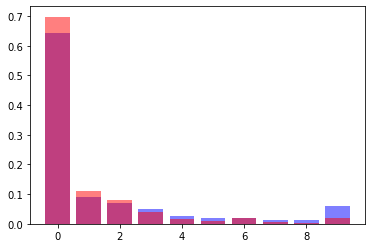

0.0005489241202637184

In [25]:
stract_hists('2050', plot=True)

In [26]:
to_exclude = []
ajusted_test = comp_test_df.copy()
for feature in comp_train_df.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title', 'accuracy']:
        data = comp_train_df[feature]
        train_mean = data.mean()
        data = comp_test_df[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print('normal', feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except Exception as e:
            to_exclude.append(feature)
            print(e, feature, train_mean, test_mean)

float division by zero ecc6157f 0.007292255511588468 0.0
float division by zero 2ec694de 0.008988128886376484 0.0
float division by zero e4d32835 0.0013001695873374789 0.0
float division by zero 01ca3a3c 0.0004522328999434709 0.0
float division by zero 4074bac2 0.0 0.0
float division by zero 1b54d27f 0.0007348784624081402 0.0
float division by zero 13f56524 0.04392312040700961 0.0
float division by zero 611485c5 0.0013566986998304127 0.0
float division by zero 29a42aea 0.004070096099491238 0.0
float division by zero 7fd1ac25 0.01978518937252685 0.0
float division by zero dcb1663e 0.0 0.0
float division by zero ab4ec3a4 0.0009044657998869418 0.0
float division by zero 0ce40006 0.0008479366873940079 0.0
normal eb2c19cd 0.17382702091577162 0.005975500448162534 0.0
float division by zero 17ca3959 0.0 0.0
float division by zero bfc77bd6 0.012832108535895986 0.0
float division by zero 119b5b02 0.0002826455624646693 0.0
float division by zero 4080Mushroom_Sorter__Assessment_ 0.043923120407009

In [27]:
len(to_exclude)

36

In [28]:
keep_cols = [c for c in comp_train_df.columns if c not in to_exclude]
comp_train_df = comp_train_df[keep_cols]
comp_test_df = comp_test_df[keep_cols]

In [29]:
comp_test_df = comp_test_df.groupby(['installation_id']).last().reset_index()

### Remove zero columns

In [30]:
numeric_cols = comp_train_df.select_dtypes(['number']).columns
all_zeros_df = (np.sum(comp_train_df[numeric_cols], axis=0) == 0).reset_index()
for zero_col in all_zeros_df[all_zeros_df[0] == True]['index']:
    del comp_train_df[zero_col]
    del comp_test_df[zero_col]

In [31]:
comp_train_df

,Clip,Activity,Assessment,Game,acc_Mushroom_Sorter__Assessment_,acc_Cart_Balancer__Assessment_,acc_Cauldron_Filler__Assessment_,acc_Bird_Measurer__Assessment_,acc_Chest_Sorter__Assessment_,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,0413e89d,d3268efa,ad2fc29c,74e5f8a7,8d84fa81,1375ccb7,15ba1109,abc5811c,d06f75b5,5859dfb6,26fd2d99,3edf6747,15a43e5b,8d7e386c,3d8c61b0,3babcb9b,6f4adc4b,a8a78786,c74f40cd,804ee27f,2a444e03,06372577,2a512369,bcceccc6,37db1c2f,5c2f29ca,7dfe6d8a,58a0de5c,499edb7c,28ed704e,36fa3ebe,022b4259,65abac75,77261ab5,cb1178ad,90efca10,a1192f43,49ed92e9,a6d66e51,565a3990,1c178d24,1340b8d7,1996c610,9e4c8c7b,db02c830,c7128948,7ec0c298,dcb55a27,e79f3763,16dffff1,b5053438,763fc34e,0db6d71d,d51b1749,df4940d3,1af8be29,923afab1,a1e4395d,2dcad279,792530f8,33505eae,00c73085,5d042115,ecc36b7f,a8876db3,b012cd7f,6c517a88,08fd73f3,a1bbe385,16667cc5,f56e0afc,25fa8af4,2b9272f4,d88ca108,d2659ab4,2b058fe3,86c924c4,f32856e4,b7dc8128,99abe2bb,5154fc30,2230fab4,c277e121,dcaede90,87d743c1,86ba578b,c7f7f0e1,5be391b5,56cd3b43,d185d3ea,9b01374f,47026d5f,d2e9262e,ad148f58,df4fe8b6,532a2afb,a592d54e,1cf54632,f50fc6c1,6f4bd64e,84538528,1325467d,b7530680,c54cf6c5,4c2ec19f,3d0b9317,f71c4741,e3ff61fb,bd701df8,c51d8688,1bb5fbdb,709b1251,e694a35b,a7640a16,83c6c409,38074c54,05ad839b,a52b92d5,5de79a6a,37c53127,7423acbc,15f99afc,c6971acf,f806dc10,4d6737eb,30614231,e7e44842,3a4be871,9b4001e4,3393b68b,77c76bc5,d88e8f25,fbaf3456,45d01abe,4d911100,4a09ace1,d45ed6a1,e080a381,28520915,c952eb01,a8efe47b,ac92046e,7ad3efc6,5e109ec3,587b5989,19967db1,5290eab1,e7561dd2,bb3e370b,3afb49e6,b88f38da,e5734469,3b2048ee,f54238ee,3d63345e,d2278a3b,3dcdda7f,f5b8c21a,4901243f,93edfe2e,8d748b58,67aa2ada,69fdac0a,6f445b57,b2e5b0f1,7372e1a5,d3640339,d38c2fd7,5f5b2617,222660ff,6043a2b4,5a848010,795e4a37,37ee8496,857f21c0,5e3ea25a,8f094001,3bb91dda,4bb2f698,6f8106d9,3ee399c3,756e5507,9ce586dd,b74258a0,7f0836bf,e4f1efe6,63f13dd7,3ccd3f02,cf7638f3,4b5efe37,392e14df,c189aaf2,28a4eb9a,7040c096,ec138c1c,b120f2ac,7da34a02,4e5fc6f5,b80e5e84,...,4020Egg_Dropper__Activity_,4080Cauldron_Filler__Assessment_,3021Cart_Balancer__Assessment_,2030Scrub_A_Dub,4070Pan_Balance,3020Air_Show,3120Chest_Sorter__Assessment_,4030Fireworks__Activity_,4090Happy_Camel,4030Flower_Waterer__Activity_,3021Happy_Camel,4035Chow_Time,4070Chicken_Balancer__Activity_,2030Dino_Drink,3110Leaf_Leader,4010Scrub_A_Dub,3010Cauldron_Filler__Assessment_,2000Heavy__Heavier__Heaviest,2000Magma_Peak___Level_1,4070Bird_Measurer__Assessment_,4095Chow_Time,3020Bird_Measurer__Assessment_,4100Mushroom_Sorter__Assessment_,2030Bottle_Filler__Activity_,5000Watering_Hole__Activity_,3020Dino_Drink,4090Bubble_Bath,4020Mushroom_Sorter__Assessment_,3120Mushroom_Sorter__Assessment_,3110Sandcastle_Builder__Activity_,4020Fireworks__Activity_,3021Mushroom_Sorter__Assessment_,2000Welcome_to_Lost_Lagoon_,2000Crystal_Caves___Level_3,2000Honey_Cake,3110Bottle_Filler__Activity_,4010Dino_Drink,2060Leaf_Leader,4080Bird_Measurer__Assessment_,3121Cauldron_Filler__Assessment_,4090Fireworks__Activity_,3110Chest_Sorter__Assessment_,4035All_Star_Sorting,4070Dino_Drink,3020Leaf_Leader,3010Leaf_Leader,2000Cart_Balancer__Assessment_,4070Flower_Waterer__Activity_,4110Air_Show,2000Egg_Dropper__Activity_,2025Bubble_Bath,2020Mushroom_Sorter__Assessment_,4040Mushroom_Sorter__Assessment_,4235Bubble_Bath,4095Happy_Camel,4020Flower_Waterer__Activity_,2020Bottle_Filler__Activity_,3010Mushroom_Sorter__Assessment_,4020Cauldron_Filler__Assessment_,3121Cart_Balancer__Assessment_,3110Chow_Time,2000Watering_Hole__Activity_,4100Pan_Balance,3121Crystals_Rule,2035Mushroom_Sorter__Assessment_,3020Happy_Camel,3021Bird_Measurer__Assessment_,3110Bird_Measurer__Assessment_,3120All_Star_Sorting,2010Cart_Balancer__Assessment_,4010Chow_Time,3121Leaf_Leader,2020Bubble_Bath,3010Bottle_Filler__Activity_,4030Pan_Balan

## Training

In [32]:
def get_class_bounds(y, y_pred, N=4, class0_fraction=-1):
    """
    Find boundary values for y_pred to match the known y class percentiles.
    Returns N-1 boundaries in y_pred values that separate y_pred
    into N classes (0, 1, 2, ..., N-1) with same percentiles as y has.
    Can adjust the fraction in Class 0 by the given factor (>=0), if desired. 
    """
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

In [33]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rsme',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'num_leaves': 31,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100,
            'eval_metric': 'cappa',
            'cat_cols': ['session_title']
            }

In [34]:
y = comp_train_df['accuracy_group']

In [35]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [36]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'accuracy']

In [37]:
## Added by Gil Fernandes
calculated_coeff = None
calculated_coeffs = []
default_coeff = [1.12232214, 1.73925866, 2.22506454]
## End

class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        self.columns = X.columns.tolist()
        
        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)
            
            ## Added by Gil Fernandes
            global calculated_coeff, calculated_coeffs
            coeff_pred = model.predict(X_train)
            calculated_coeff = get_class_bounds(y_train, coeff_pred)
            optR = OptimizedRounder(calculated_coeff)
            optR.fit(coeff_pred, y_train)
            calculated_coeffs.append(optR.coefficients())
            print('calculated_coeffs', calculated_coeffs)
            ## End

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        for i in range(len(self.models)):
            X_t = X_test.copy()

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

In [38]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

In [39]:

def convert_regr_to_cat(y_pred, my_coeffs=default_coeff):
    zero_threshhold = my_coeffs[0]
    one_threshhold = my_coeffs[1]
    two_threshhold = my_coeffs[2]
    y_pred = y_pred.copy()
    y_pred[y_pred <= zero_threshhold] = 0
    y_pred[np.where(np.logical_and(y_pred > zero_threshhold, y_pred <= one_threshhold))] = 1
    y_pred[np.where(np.logical_and(y_pred > one_threshhold, y_pred <= two_threshhold))] = 2
    y_pred[y_pred > two_threshhold] = 3
    return y_pred

def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    my_coeffs = default_coeff if len(calculated_coeffs) == 0 else np.mean(calculated_coeffs, axis=0)
    y_pred = convert_regr_to_cat(y_pred, my_coeffs)

    return 'cappa', qwk(y_true, y_pred), True

In [40]:
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

In [41]:
from functools import partial
import scipy as sp

default_coef = [0.5, 1.5, 2.25]

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self, initial_coef = default_coef):
        self.coef_ = 0
        self.initial_coef = initial_coef

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        self.coef_ = sp.optimize.minimize(loss_partial, self.initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

Fold 1 started at Wed Jan 22 19:35:04 2020


/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['session_title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	train's cappa: 0.75249	valid's cappa: 0.709244
[200]	train's cappa: 0.796325	valid's cappa: 0.714498
[300]	train's cappa: 0.826428	valid's cappa: 0.71859
Early stopping, best iteration is:
[235]	train's cappa: 0.807703	valid's cappa: 0.720575
calculated_coeffs [array([1.04347804, 1.68110891, 2.28760196])]
Fold 2 started at Wed Jan 22 19:35:23 2020
Training until validation scores don't improve for 100 rounds
[100]	train's cappa: 0.75455	valid's cappa: 0.701514
[200]	train's cappa: 0.797238	valid's cappa: 0.706964
[300]	train's cappa: 0.826005	valid's cappa: 0.708323
Early stopping, best iteration is:
[270]	train's cappa: 0.81786	valid's cappa: 0.709767
calculated_coeffs [array([1.04347804, 1.68110891, 2.28760196]), array([1.00104277, 1.64382549, 2.30669884])]
Fold 3 started at Wed Jan 22 19:35:43 2020
Training until validation scores don't improve for 100 rounds
[100]	train's cappa: 0.753035	valid's cappa: 0.697164
[20

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


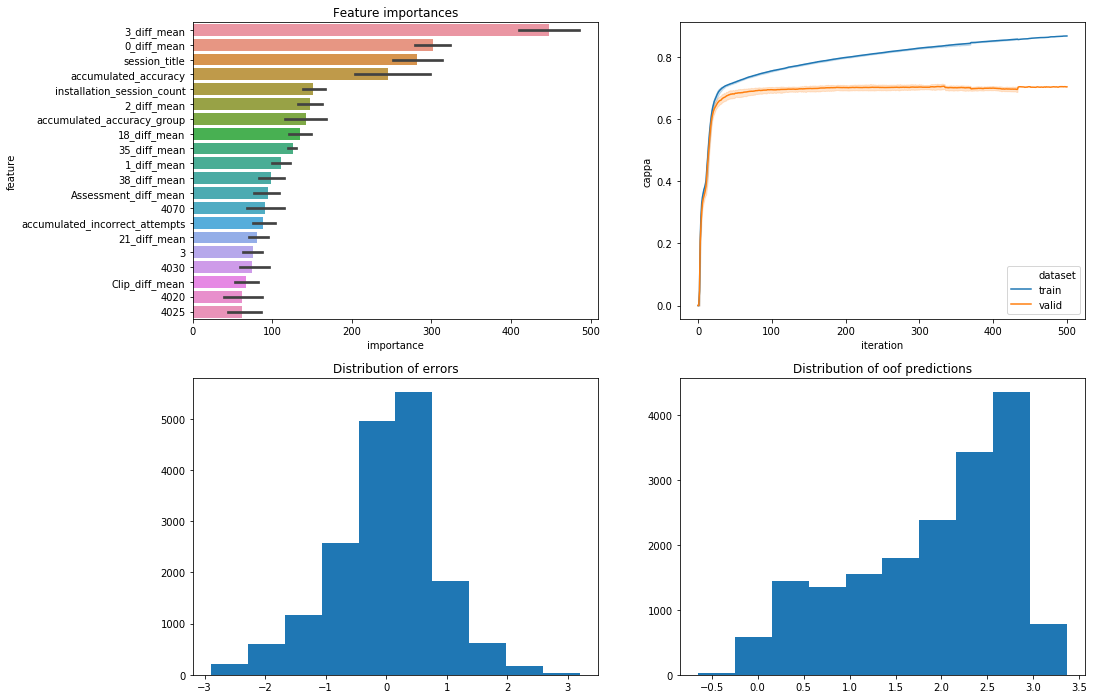

In [42]:
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=comp_train_df, y=y, folds=folds, params=params,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

## Inference

In [43]:
%%time
pr1 = regressor_model1.predict(comp_train_df)
calculated_coeffs_mean = np.mean(calculated_coeffs, axis=0)

CPU times: user 13.8 s, sys: 1.64 s, total: 15.5 s
Wall time: 1.56 s


In [44]:
optR = OptimizedRounder(calculated_coeffs_mean)
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

In [45]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.8102535411261429

In [46]:
pr1 = regressor_model1.predict(comp_test_df)

(array([ 15.,  54.,  61.,  69.,  65., 114., 168., 227., 170.,  57.]),
 array([-0.24391724,  0.08011759,  0.40415241,  0.72818724,  1.05222207,
         1.37625689,  1.70029172,  2.02432655,  2.34836137,  2.6723962 ,
         2.99643102]),
 <a list of 10 Patch objects>)

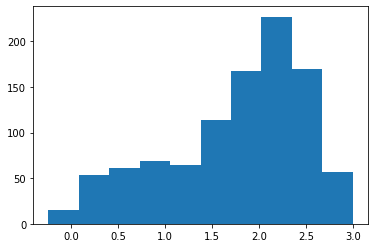

In [47]:
plt.hist(pr1.reshape(-1,))

In [48]:
pr1 = convert_regr_to_cat(pr1)
pd.Series(pr1.reshape(1000)).value_counts(normalize=True)

2.0    0.302
3.0    0.298
0.0    0.216
1.0    0.184
dtype: float64

In [49]:
print(calculated_coeffs_mean)
pr2 = regressor_model1.predict(comp_test_df)
pr2 = convert_regr_to_cat(pr2, calculated_coeffs_mean)
pd.Series(pr2.reshape(1000)).value_counts(normalize=True)
# default_coeff = [1.12232214, 1.73925866, 2.22506454]
# [1.09505532 1.71880488 2.24610138]
# [1.14125791 1.72672698 2.25271355]
# [1.10772266 1.75043088 2.25359742]

[1.04162905 1.66468516 2.26913042]


2.0    0.383
3.0    0.266
0.0    0.196
1.0    0.155
dtype: float64

## Using original distribution in train set

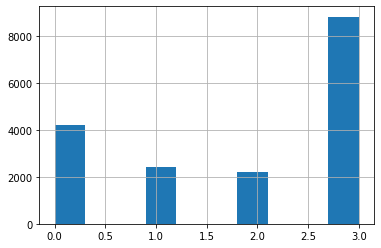

In [50]:
dist = Counter(comp_train_df['accuracy_group'])
for k in dist:
    dist[k] /= len(comp_train_df)
comp_train_df['accuracy_group'].hist()

In [51]:
acum = 0
bound = {}
final_pred = regressor_model1.predict(comp_test_df)
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

{0: 1.2354742182418244, 1: 1.6983608967562218, 2: 1.9380155622634996}


In [52]:
pr3 = convert_regr_to_cat(final_pred, bound)

In [53]:
pd.Series(pr3.reshape(1000)).value_counts()

3.0    625
0.0    241
1.0    134
dtype: int64

In [54]:
sample_submission_df = pd.read_csv(path/'sample_submission.csv')

In [55]:
selected_pred = pr2
sample_submission_df['accuracy_group'] = selected_pred.astype(int)
sample_submission_df.to_csv('submission.csv', index=False)

In [56]:
sample_submission_df.to_csv('submission.csv', index = False)

In [57]:
!head submission.csv

installation_id,accuracy_group
00abaee7,3
01242218,2
017c5718,2
01a44906,3
01bc6cb6,2
02256298,3
0267757a,1
027e7ce5,2
02a29f99,0


## Data Checks

In [58]:
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]
valid_ds = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy']
expected_ratios = valid_ds.apply(lambda x : feature_engineering.convert_to_accuracy_group(x)).value_counts(normalize=True)
expected_ratios

3    0.450747
0    0.283066
1    0.137244
2    0.128943
Name: accuracy, dtype: float64

In [59]:
pred_ratios = sample_submission_df['accuracy_group'].value_counts(normalize=True)
pred_ratios

2    0.383
3    0.266
0    0.196
1    0.155
Name: accuracy_group, dtype: float64

In [60]:
pred_ratios_list = np.array(pred_ratios.sort_index().tolist())
expected_ratios_list = np.array(expected_ratios.sort_index().tolist())
pred_ratios_list, expected_ratios_list

(array([0.196, 0.155, 0.383, 0.266]),
 array([0.28306586, 0.13724405, 0.128943  , 0.45074709]))

In [61]:
prod = ((pred_ratios_list - pred_ratios_list.mean()) * (expected_ratios_list - expected_ratios_list.mean())).mean() / (pred_ratios_list.std() * expected_ratios_list.std())
prod

-0.08740745317678557

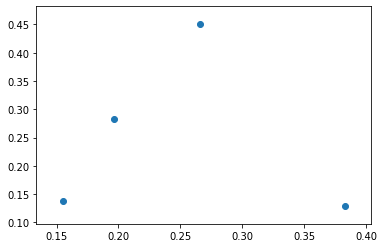

In [62]:
plt.scatter(pred_ratios_list, expected_ratios_list);